In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2
import imageio
import matplotlib.image as mpimg
from skimage import io
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import RMSprop,SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from statistics import mode
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-05-21 07:23:31.828511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 07:23:31.828620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 07:23:31.954215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def prepare_dataset(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224,224), cv2.INTER_AREA)
            img=img/255.0
            img_rgb = gray2RGB(img)
            if i < 100000:
                
                x_data.append(img_rgb)
                dataX.append(img_rgb)
                y_data.append(label)
                dataY.append(label)
            else: 
                break
            
            i = i + 1
    
    return  np.array(dataX),np.array(dataY)




def prepare_dataset_2(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224, 224), cv2.INTER_AREA)
            img_rgb = gray2RGB(img)
            lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
            l = lab[:,:,0]
            a = lab[:,:,1]
            b = lab[:,:,2]
            
            #Geleneksel equalazation yapalım.
            equalized = cv2.equalizeHist(l)
            
            #Kanalları birleştirelim.
            lab_img1_result = cv2.merge((equalized,a,b))
            
            #Lab formatımızı eski haline bgr haline dönüştürelim
            hist_eq_img = cv2.cvtColor(lab_img1_result, cv2.COLOR_LAB2BGR)
            hist_eq_img = hist_eq_img/255
            
            results = lab_img1_result / 255
            
            if i < 1500: 
                x_data.append(hist_eq_img)
                dataX.append(hist_eq_img)
                y_data.append(label)
                dataY.append(label)
            else:
                break
            
            i = i + 1
    
    return  np.array(dataX),np.array(dataY)


def prepare_dataset_clahe(path,label):
    dataX=[]
    dataY=[]
    all_images_path=glob.glob(path+'/*')
    i = 0
    for img_path in all_images_path:        
            image = io.imread(img_path)
            img = cv2.resize(image, (224, 224), cv2.INTER_AREA)
            img_rgb = gray2RGB(img)
            lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
            l = lab[:,:,0]
            a = lab[:,:,1]
            b = lab[:,:,2]
            
            #Geleneksel equalazation yapalım.
            equalized = cv2.equalizeHist(l)
            
            #Kanalları birleştirelim.
            lab_img1_result = cv2.merge((equalized,a,b))
            
            #Lab formatımızı eski haline bgr haline dönüştürelim
            hist_eq_img = cv2.cvtColor(lab_img1_result, cv2.COLOR_LAB2BGR)
            hist_eq_img = hist_eq_img/255
            
            results = lab_img1_result / 255
            
            if i < 1800:
                x_data.append(hist_eq_img)
                dataX.append(hist_eq_img)
                y_data.append(label)
                dataY.append(label)
            else: 
                break
                
            i = i + 1
            
    return  np.array(dataX),np.array(dataY)




In [3]:
def gray2RGB(array2d):
    array3d = np.tile(array2d[:,:,np.newaxis],3)
    return array3d

def all_img_rgb_converter(arrays2d):

    len, width, height = arrays2d.shape
    arrays3d = []

    for i in range(len):
        array3d = gray2RGB(arrays2d[i,:,:])
        arrays3d.append(array3d)

    arrays3d = np.array(arrays3d)
    return arrays3d

In [4]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [5]:
def accuracy_lr_loss_plot(history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(231)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(232)
    plt.plot(history.history['learning_rate'], 'go--', label="Learning Rate")
    plt.title("Learning Rate")
    plt.xlabel("Number of epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(233)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()


In [6]:
x_data = []
y_data = []

In [7]:
Mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented"
Moderate_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented"
Non_Demented_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented"
Very_mild_Dementia_test = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented"

In [8]:
Mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented"
Moderate_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented"
Non_Demented_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented"
Very_mild_Dementia_train = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented"

In [9]:
X_Mild_Dementia_test, Y_Mild_Dementia_test =  prepare_dataset_clahe(Mild_Dementia_test,0)
X_Moderate_Dementia_test, Y_Moderate_Dementia_test =  prepare_dataset_clahe(Moderate_Dementia_test,0)
X_Non_Demented_test, Y_Non_Demented_test = prepare_dataset_2(Non_Demented_test,1)
X_Very_mild_Dementia_test, Y_Very_mild_Dementia_test = prepare_dataset_clahe(Very_mild_Dementia_test,0)

In [10]:
X_Mild_Dementia_train, Y_Mild_Dementia_train =  prepare_dataset_clahe(Mild_Dementia_train,0)
X_Moderate_Dementia_train, Y_Moderate_Dementia_train =  prepare_dataset_clahe(Moderate_Dementia_train,0)
X_Non_Demented_train, Y_Non_Demented_train = prepare_dataset_2(Non_Demented_train,1)
X_Very_mild_Dementia_train, Y_Very_mild_Dementia_train = prepare_dataset_clahe(Very_mild_Dementia_train,0)

In [11]:
c_0 = 0
c_1 = 0
    
for i in y_data:
    if i == 0:
        c_0 += 1 
    elif i == 1:
        c_1 += 1
    else:
        print("asfaa")

In [12]:
c_0

3200

In [13]:
c_1

1640

In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16

2024-05-25 05:06:14.517420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 05:06:14.517517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 05:06:14.638609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 5)


In [2]:
################# DenseNet121 ##################
pretrained_model=DenseNet121(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet')
for layer in pretrained_model.layers:
            layer.trainable = False

for layer in pretrained_model.layers[313:]:
            layer.trainable = True

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
for i, layer in enumerate(pretrained_model.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 False 	  : input_layer
1 	 False 	  : zero_padding2d
2 	 False 	  : conv1_conv
3 	 False 	  : conv1_bn
4 	 False 	  : conv1_relu
5 	 False 	  : zero_padding2d_1
6 	 False 	  : pool1
7 	 False 	  : conv2_block1_0_bn
8 	 False 	  : conv2_block1_0_relu
9 	 False 	  : conv2_block1_1_conv
10 	 False 	  : conv2_block1_1_bn
11 	 False 	  : conv2_block1_1_relu
12 	 False 	  : conv2_block1_2_conv
13 	 False 	  : conv2_block1_concat
14 	 False 	  : conv2_block2_0_bn
15 	 False 	  : conv2_block2_0_relu
16 	 False 	  : conv2_block2_1_conv
17 	 False 	  : conv2_block2_1_bn
18 	 False 	  : conv2_block2_1_relu
19 	 False 	  : conv2_block2_2_conv
20 	 False 	  : conv2_block2_concat
21 	 False 	  : conv2_block3_0_bn
22 	 False 	  : conv2_block3_0_relu
23 	 False 	  : conv2_block3_1_conv
24 	 False 	  : conv2_block3_1_bn
25 	 False 	  : conv2_block3_1_relu
26 	 False 	  : conv2_block3_2_conv
27 	 False 	  : conv2_block3_concat
28 	 False 	  : conv2_block4_0_bn
29 	 False 	  : conv2_block4_0_relu
30 

In [16]:
VALIDATION_ACCURACY_DenseNet121 = []
VALIDAITON_LOSS_DenseNet121 = []

fold-1 data verileri atlandı
fold-2 data verileri atlandı
fold-3 data verileri atlandı
fold-4 data verileri atlandı
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1716276346.182825     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716276346.297172     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6393 - loss: 0.9124

W0000 00:00:1716276369.158950     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.34194, saving model to /kaggle/working/DenseNet121_model_5.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 113s 330ms/step - accuracy: 0.6397 - loss: 0.9106 - val_accuracy: 0.3419 - val_loss: 49.9657 - learning_rate: 0.0100
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7628 - loss: 0.5216
Epoch 2: val_accuracy improved from 0.34194 to 0.73244, saving model to /kaggle/working/DenseNet121_model_5.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.7629 - loss: 0.5215 - val_accuracy: 0.7324 - val_loss: 1.8164 - learning_rate: 0.0100
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8022 - loss: 0.4376
Epoch 3: val_accuracy improved from 0.73244 to 0.80062, saving model to /kaggle/working/DenseNet121_model_5.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.8023 - loss: 0.4374 - val_accuracy: 0.8006 - val_loss: 0.7809 - learning_rate: 0.0100
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

W0000 00:00:1716276989.535352     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step


<Figure size 640x480 with 0 Axes>

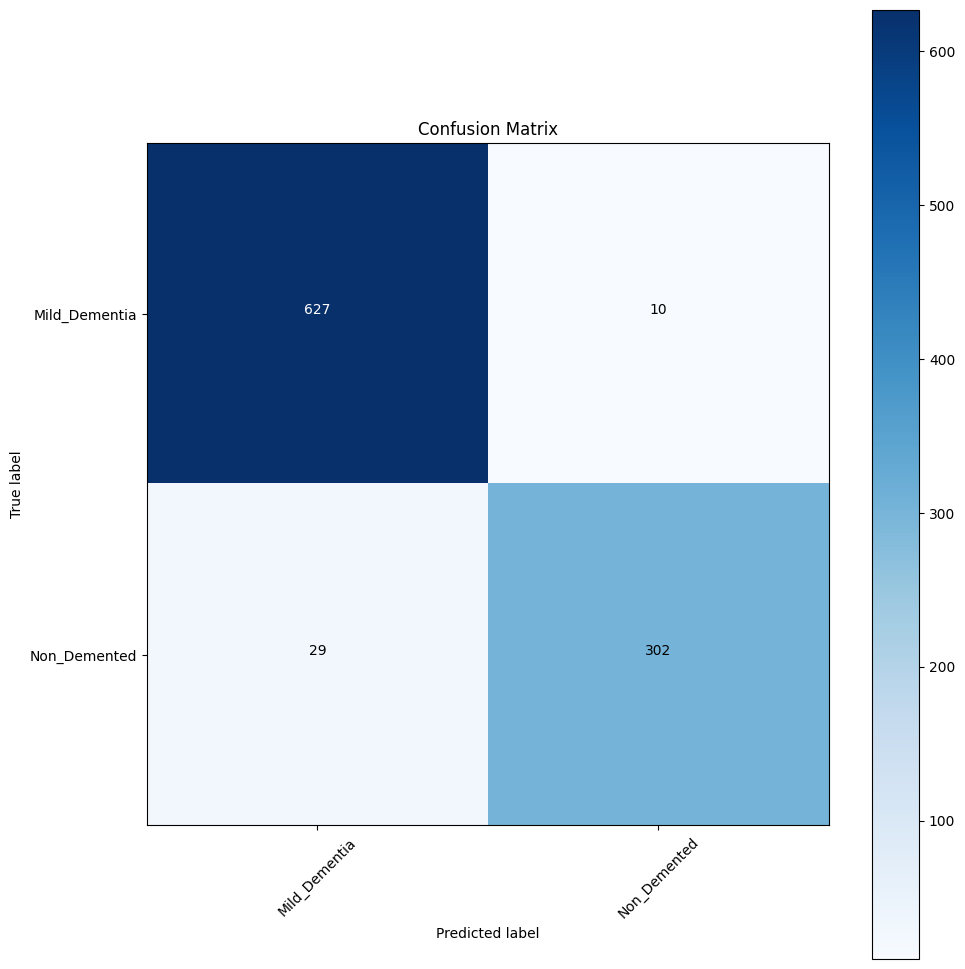

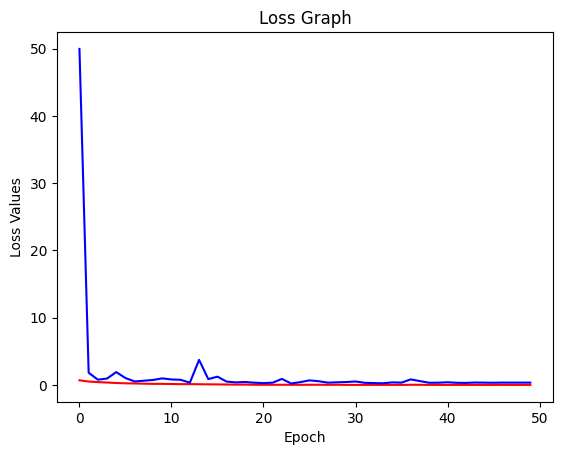

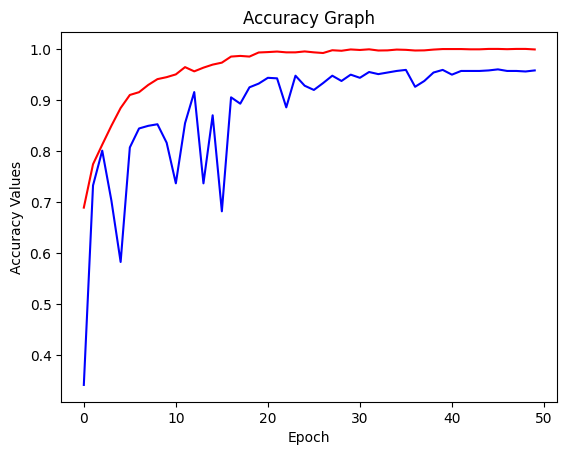

[0.9597107172012329]
[0.3274676203727722]


<Figure size 640x480 with 0 Axes>

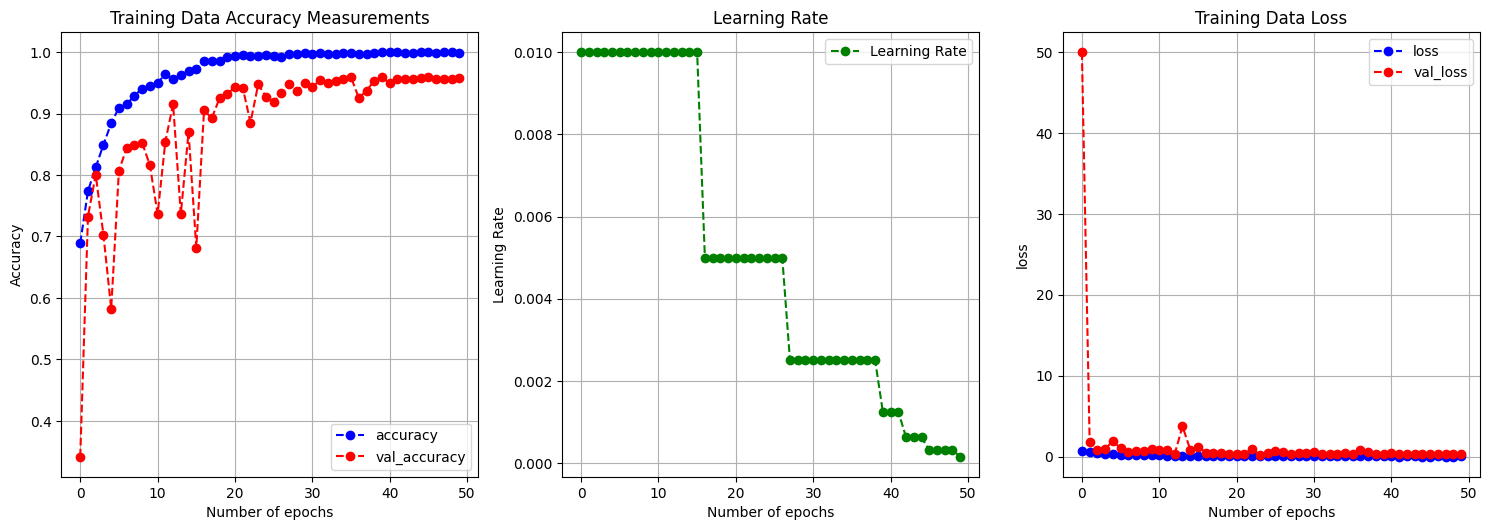

In [17]:
fold_var = 1

desired_fold = 5

for train_index, val_index in kf.split(x_data,y_data):
    
    if fold_var == desired_fold: 
        x_train_data = []
        y_train_data = []

        x_val_data = []
        y_val_data = []


        for i in train_index:
          x_train_data.append(x_data[i])
          y_train_data.append(y_data[i])


        for i in val_index:
          x_val_data.append(x_data[i])
          y_val_data.append(y_data[i])


        X_train = np.array(x_train_data)
        Y_train = np.array(y_train_data)

        X_val = np.array(x_val_data)
        Y_val = np.array(y_val_data)

        ################# DenseNet121 ##################
        pretrained_model=DenseNet121(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet')

        for layer in pretrained_model.layers:
            layer.trainable = False

        for layer in pretrained_model.layers[313:]:
            layer.trainable = True


        # Define custom head for classification
        x = pretrained_model.output
        # x = Dropout(0.5)(x)
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)
        x = Dense(8192, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(4096, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2048, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        output = Dense(2, activation='softmax')(x)



        final_DenseNet121 = Model(inputs=pretrained_model.input, outputs=output)



        final_DenseNet121.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])


        #.h5 = Hierarchical Data Format Ver. 5 file, verbose =1, to see execution
        tensorboard= tf.keras.callbacks.TensorBoard(log_dir="logs")
        checkpoint= tf.keras.callbacks.ModelCheckpoint(f"/kaggle/working/DenseNet121_model_{fold_var}.keras",
                                monitor="val_accuracy", verbose=1,
                                mode="auto", save_best_only=True)

        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)


        #monitor: quantity to be monitored.     
        #factor: factor by which the learning rate will be reduced. 
        #patience: number of epochs with no improvement after which learning rate will be reduced.     
        #verbose: int. 0: quiet, 1: update messages.
        #min_delta: early stopping of epochs
        reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                factor=0.5,
                                patience=3,verbose=1,
                                mode="auto", min_delta=0.001)



        history = final_DenseNet121.fit(X_train,Y_train,
                epochs=50,
                validation_data=(X_val,Y_val),
                callbacks =[tensorboard, checkpoint, reduce_lr])



        # LOAD BEST MODEL to evaluate the performance of the model
        final_DenseNet121.load_weights(f"/kaggle/working/DenseNet121_model_{fold_var}.keras")

        results = final_DenseNet121.evaluate(X_val,Y_val)
        results = dict(zip(final_DenseNet121.metrics_names,results))


        VALIDATION_ACCURACY_DenseNet121.append(results['compile_metrics'])
        VALIDAITON_LOSS_DenseNet121.append(results['loss'])


        #  Logic of all test database
        Y_pred = final_DenseNet121.predict(X_val)
        Y_pred = np.argmax(Y_pred, axis=1)


        #  Return pro format of classes
        target_names = ["Mild_Dementia", "Non_Demented"]

        # Confusion Matrix
        plt.figure()
        cm = confusion_matrix(Y_val, Y_pred)
        plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

        # Save confusion matrix in text
        np.savetxt(f"/kaggle/working/DenseNet121_cm_{fold_var}.txt",cm,fmt='%d')
        plt.savefig(f"/kaggle/working/DenseNet121_cm_img_{fold_var}.png")

        # Save clasification report in text
        text_file = open(f"/kaggle/working/DenseNet121_report_{fold_var}.txt", "w")
        n = text_file.write(classification_report(Y_val, Y_pred, target_names=target_names))
        text_file.close()

        #Comparing losses and accuraries 
        plt.figure()
        plt.plot(history.history['loss'], color='r')
        plt.plot(history.history['val_loss'], color='b')
        plt.title("Loss Graph")
        plt.xlabel("Epoch")
        plt.ylabel("Loss Values")
        plt.savefig(f"/kaggle/working/DenseNet121_loss_{fold_var}.png")
        plt.show()

        plt.figure()
        plt.plot(history.history['accuracy'], color='r')
        plt.plot(history.history['val_accuracy'], color='b')
        plt.title("Accuracy Graph")
        plt.ylabel("Accuracy Values")
        plt.xlabel("Epoch")
        plt.savefig(f"/kaggle/working/DenseNet121_accuracy_{fold_var}.png")
        plt.show()

        plt.figure()
        print(VALIDATION_ACCURACY_DenseNet121)
        print(VALIDAITON_LOSS_DenseNet121)

        accuracy_lr_loss_plot(history)

    
    elif fold_var != desired_fold:
        print(f"fold-{fold_var} data verileri atlandı")
    else:
        print("yanlış bişeyler var hacı")
        
    fold_var += 1
    tf.keras.backend.clear_session() 
    
    